# Lab 7: value iteration

## Frozen Lake

Let's look at a Frozen Lake environment. It's a grid-world with a goal and a chance that some movements will slip and perform a random action. Moreover, there are some dangerous areas that terminate the episode with large penalty.

Let's have a such environment:
- Illegal state cannot be visited by the agent. This is for example the wall ('#' symbol).
- Terminal state is absorbing, there are no transitions leading from the state - game ends when it is visited by the agent. Note that walls ('#' symbol) are terminal states as well, although they can never be accessed by the agent.

In [1]:
import numpy as np, random
import matplotlib.pyplot as plt
from typing import List, Tuple

#set random seed.
random.seed(0)
np.random.seed(0)

example_map =  ["#########",
                "#       #",
                "#       #",
                "# ooooo #",
                "#   #  G#",
                "#########"]

# # = wall
# G = goal
# o = pit

Action = str # Action corresponds to a movement ['^', 'v', '<', '>'].
State = Tuple[int, int]  # State corresponds to a coordinate in the map.

class FrozenLake():
  ILLEGAL  = {"#"}
  TERMINAL = {"o", "G", "#"}
  REWARDS  = {
    "#": -0.1,
    " ": -0.1,
    "G":  1,
    "o": -10
    }
  MOVE_DIFFS = {
    '^': [-1,  0], # Move up.
    '<': [ 0, -1], # Move down.
    '>': [ 0,  1], # Move left.
    'v': [ 1,  0], # Move right.
    }

  def __init__(self, map: List[str], slip_probability: float):
    self.map = [list(row) for row in map]
    self.slip_probability = slip_probability 

  def num_rows(self) -> int:
    return len(self.map)

  def num_cols(self) -> int:
    return len(self.map[0])

  def actions(self) -> List[Action]:
    ''' Return all possible actions '''
    return self.MOVE_DIFFS.keys()

  def get_non_terminal_states(self) -> List[State]:
    ''' Return all non terminal states'''
    non_terminal_states = []
    for i in range(self.num_rows()):
      for j in range(self.num_cols()):
        if self.map[i][j] not in self.TERMINAL:
          non_terminal_states.append((i,j))
    return non_terminal_states

  def get_transitions(self, state: State, action: Action) -> List[Tuple[State, float, float]]:
    ''' Given state and action, return all probabilities of transitions. '''
    transitions = []
    if self.map[state[0]][state[1]] in self.TERMINAL:
      return []

    for a in self.actions():
      di, dj = self.MOVE_DIFFS[a]
      next_state = (state[0] + di, state[1] + dj)
      
      symbol = self.map[next_state[0]][next_state[1]]
      if symbol in self.ILLEGAL:
        next_state = state

      reward = self.REWARDS[symbol]

      if a == action:
        prob = (1 - self.slip_probability) + (self.slip_probability / len(self.actions()))
      else:
        prob = self.slip_probability / len(self.actions())

      transitions.append((next_state, prob, reward))
    return transitions

Let's have a look at the transisitons form [3, 7] state with MOVE_DOWN (just up of the goal).

Q: What are all possible transitions returned by get_transitions if we set slip probability to 0.1? List each possible next state, its probability, and the associated reward.



In [3]:
map = ["#########",
       "#       #",
       "#       #",
       "# ooooo #",
       "#   #  G#",
       "#########"]

lake = FrozenLake(map, slip_probability=0.1)
print(lake.get_transitions([3, 7], 'v'))

[((2, 7), 0.025, -0.1), ((3, 6), 0.025, -10), ([3, 7], 0.025, -0.1), ((4, 7), 0.925, 1)]


## Value Iteration

Now, let's implement the Value Iteration algorithm. Remember how it goes:

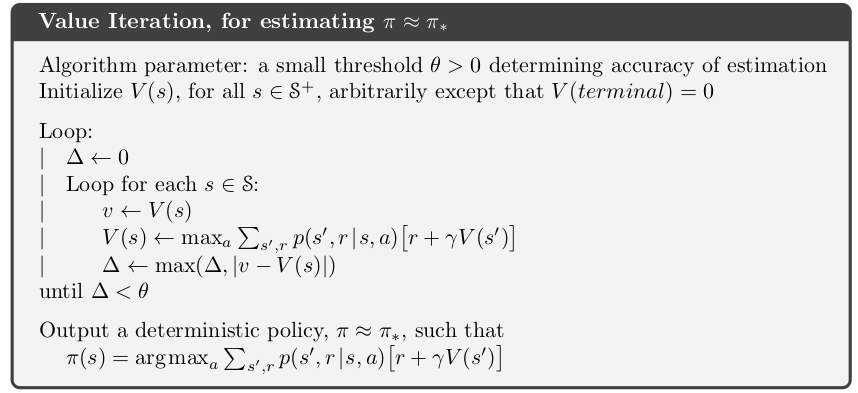

In [8]:
# Auxiliary method to plot the values.
def plot_v(v: np.array, labels=None):
  im = plt.imshow(v, vmin=-2., vmax=1.)

  if labels is None:
    labels = v

  # Loop over data dimensions and create text annotations.
  for i in range(v.shape[0]):
    for j in range(v.shape[1]):
      if labels.dtype == np.float32:
        label = f"{labels[i, j]:.2f}"
      else:
        label = labels[i, j]

      text = plt.text(j, i, label, ha="center", va="center", color="w")

  plt.tight_layout()
  plt.show()


# Compute the expected value for transitions from the same state and current values v.
# we'll call it like `get_expected_value( problem.get_transitions(s, a), v, gamma )`
def get_expected_value(transitions: List[Tuple[State, float, float]], 
                       v: np.array, 
                       gamma: float) -> float:
  # Task:
  # - return expected reward for the list of transitions
  # - we assume that the transitions come from problem.get_transitions()
  #   and that their probabilities sum to one

  v_exp = 0.
  for s, p, r in transitions:
      v_exp += p * (r + gamma * v[s])

  return v_exp

# Run the value iteration algorithm.
def value_iteration(problem: FrozenLake, gamma: float, threshold: float = 0.01):
  v: np.array = np.zeros_like(problem.map, dtype=np.float32)
  plot_v(v)

  delta = np.inf
  step = 0
  while delta > threshold:
      v_new = v.copy()
      step += 1
      for s in problem.get_non_terminal_states():
          q = []
          for a in problem.actions():
              q.append(get_expected_value(problem.get_transitions(s, a), v, gamma))
          v_new[s] = max(q)
      delta = np.max(np.abs(v_new - v))
      v = v_new
      print(f"Step {step}, MaxDelta: {delta}")
      plot_v(v)
  # Task:
  # - implement the value iteration algorithm
  # - hint: see the pseudocode above

  return v

Let's try it on a simple map:

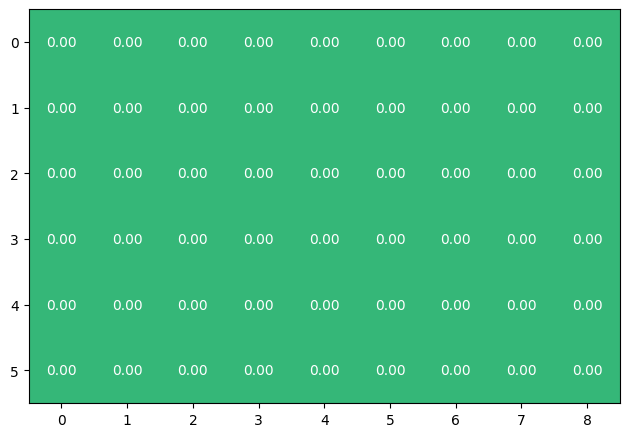

Step 1, MaxDelta: 0.6700000166893005


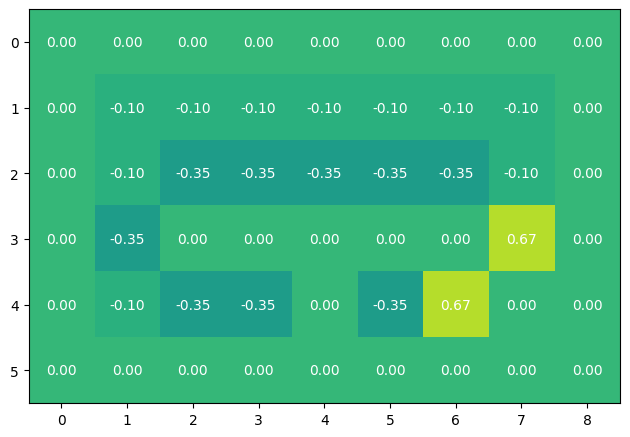

Step 2, MaxDelta: 0.6000019311904907


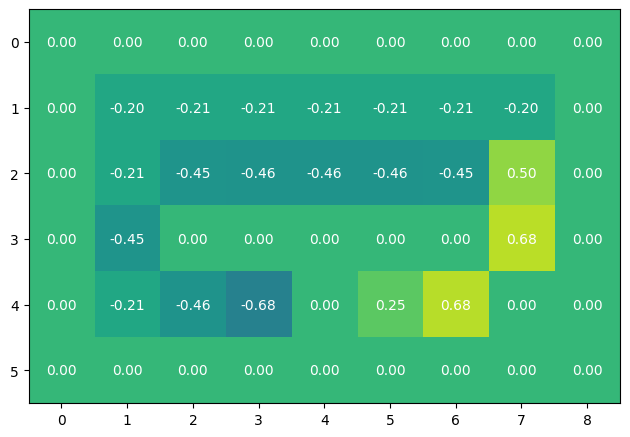

Step 3, MaxDelta: 0.5441576242446899


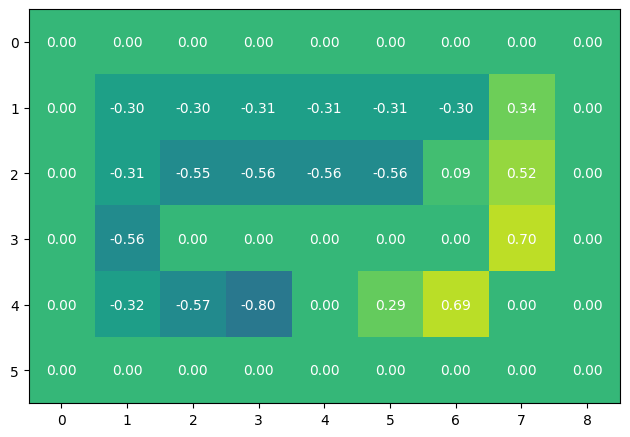

Step 4, MaxDelta: 0.5047445297241211


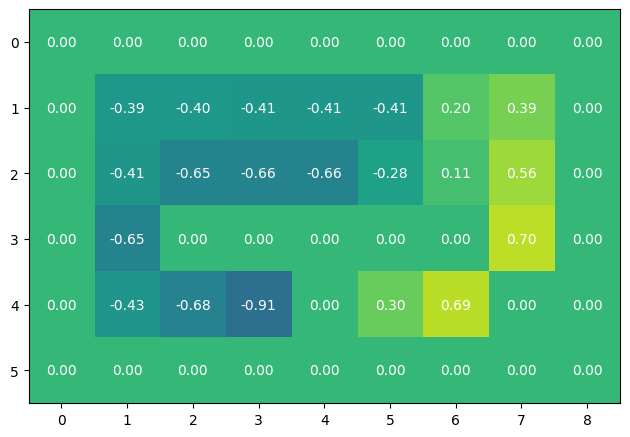

Step 5, MaxDelta: 0.4640527367591858


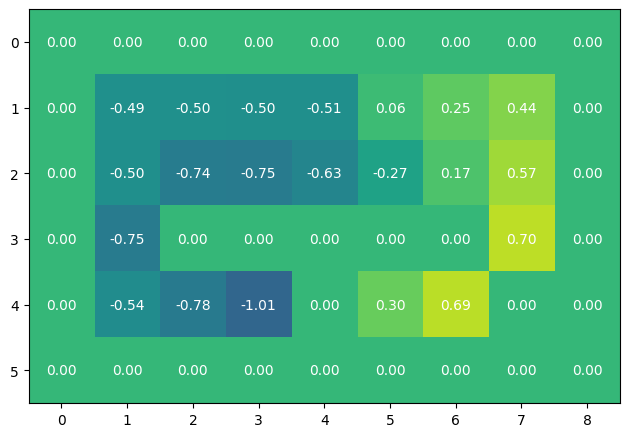

Step 6, MaxDelta: 0.4207828938961029


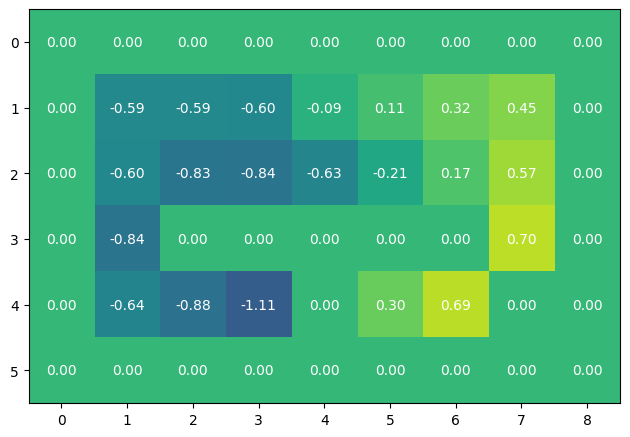

Step 7, MaxDelta: 0.3679739832878113


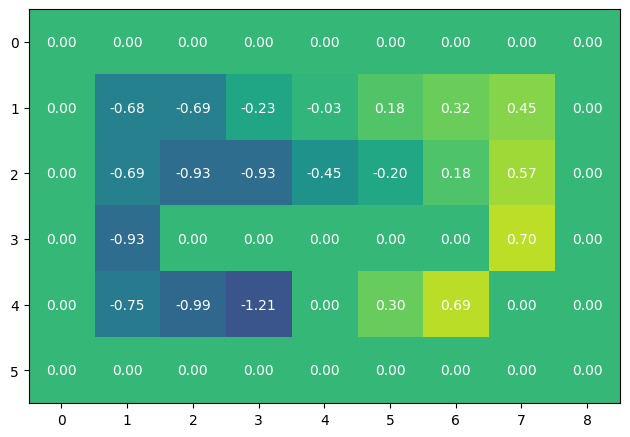

Step 8, MaxDelta: 0.33900731801986694


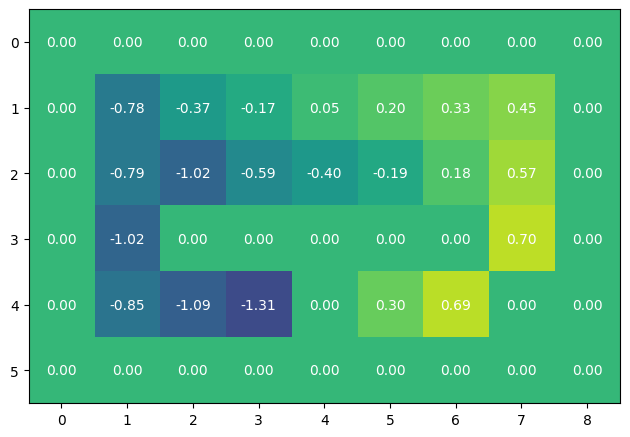

Step 9, MaxDelta: 0.29812347888946533


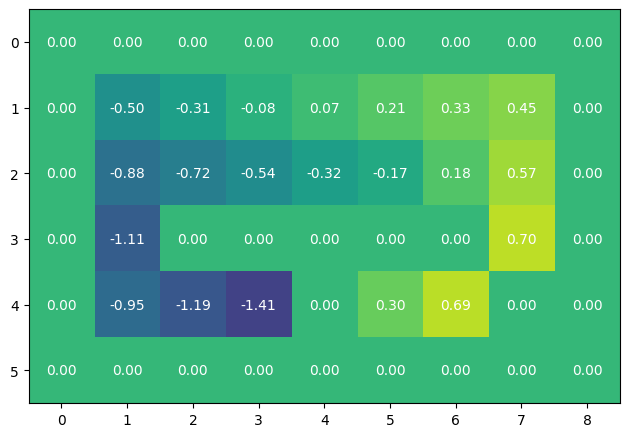

Step 10, MaxDelta: 0.25893014669418335


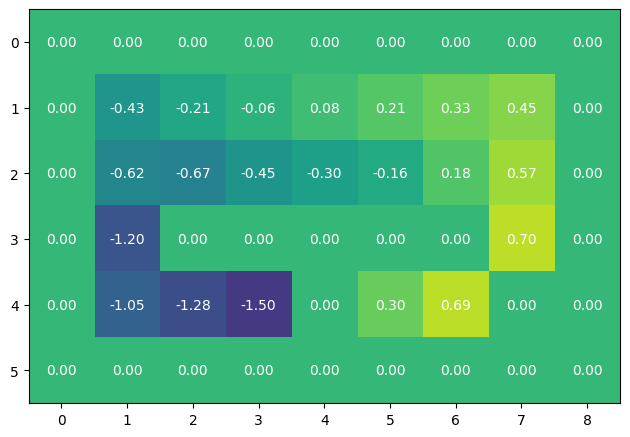

Step 11, MaxDelta: 0.23241722583770752


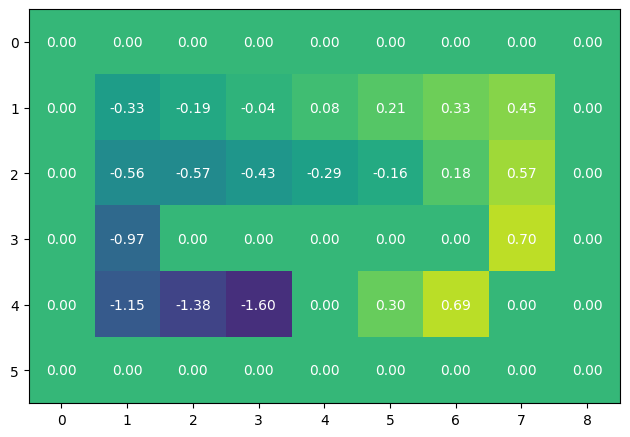

Step 12, MaxDelta: 0.10134407877922058


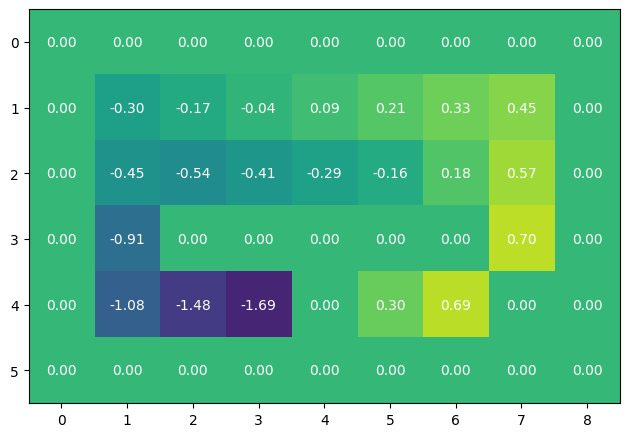

Step 13, MaxDelta: 0.09608757495880127


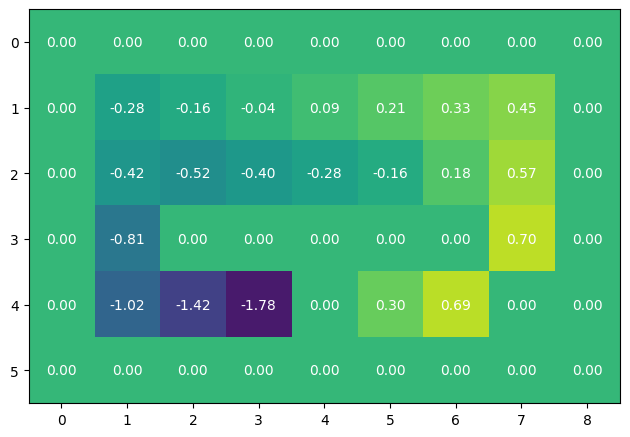

Step 14, MaxDelta: 0.0923541784286499


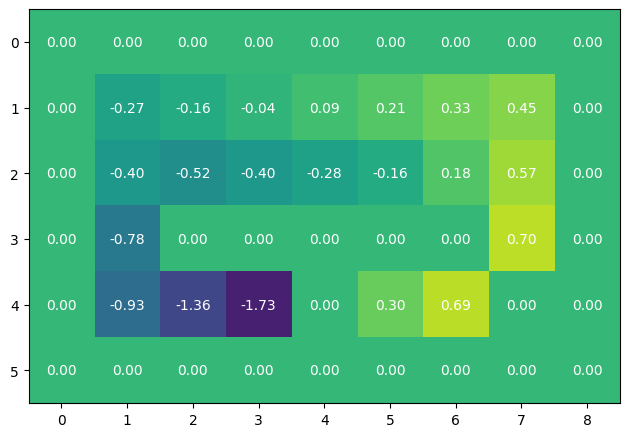

Step 15, MaxDelta: 0.08711230754852295


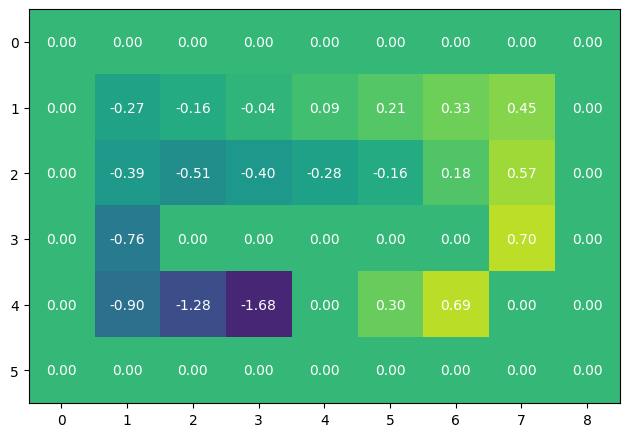

Step 16, MaxDelta: 0.0822824239730835


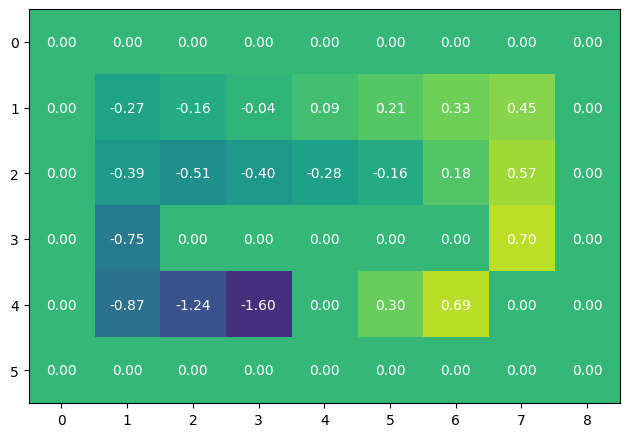

Step 17, MaxDelta: 0.036196231842041016


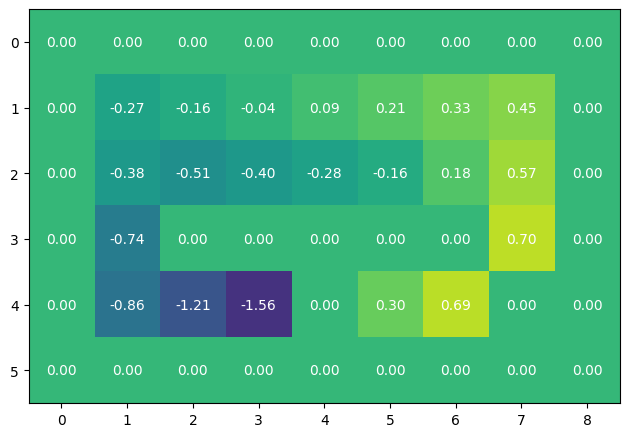

Step 18, MaxDelta: 0.027624964714050293


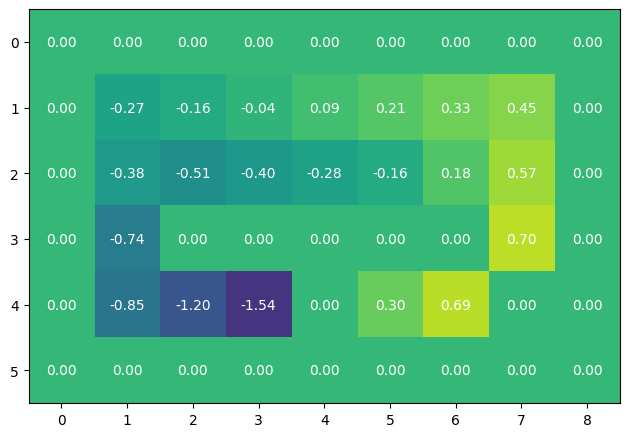

Step 19, MaxDelta: 0.011591076850891113


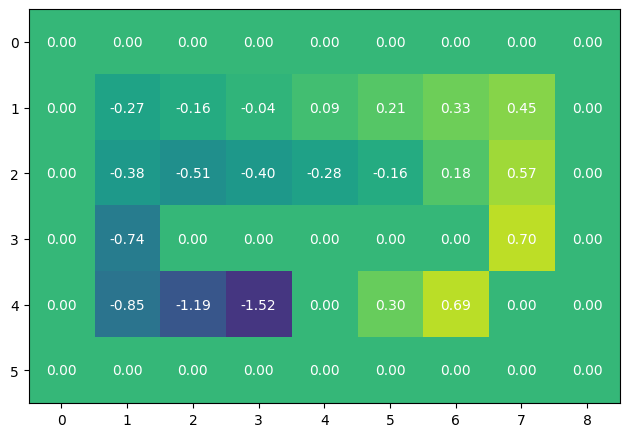

Step 20, MaxDelta: 0.006857872009277344


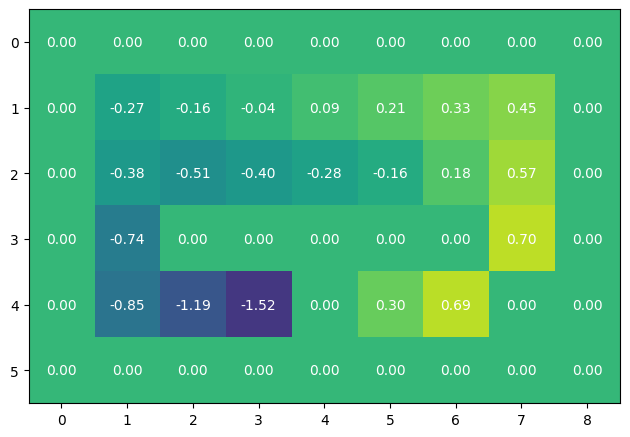

In [9]:
GAMMA = 0.99
SLIP_PROBABILITY = 0.1

lake = FrozenLake(map, SLIP_PROBABILITY)
v = value_iteration(lake,  GAMMA)

Look above at the graphs.

**Question**: Why do we need set a discount factor ($\gamma$)?


**Question**: Why do the walls, the pit and goal have 0. value?


**Question**: Why are the values high in the right bottom and low in left bottom?


**Question**: In the step 1, explain how was the value at v[4, 1] = -0.1 computed.


**Question**: In the step 1, explain how was the value at v[3, 1] = -0.35 computed.


**Question**: In the last step 20, explain how was the value at v[3, 7] = 0.70 computed.



**Question**: Look at the resulting value function, what is the optimal policy?

Let's show how the policy looks:

In [10]:
def get_policy(problem: FrozenLake, v: np.array, gamma: float):
  pi: np.array = np.full_like(problem.map, ' ', dtype=object)
  # pi is now an array of characters.

  actions = list(problem.actions())
  for s in problem.get_non_terminal_states():
      q = []
      for a in problem.actions():
          q.append(get_expected_value(problem.get_transitions(s, a), v, gamma))

      pi[s] = actions[np.argmax(q)]

  # Task
  # - update pi so it contains the best action for each state

  return pi

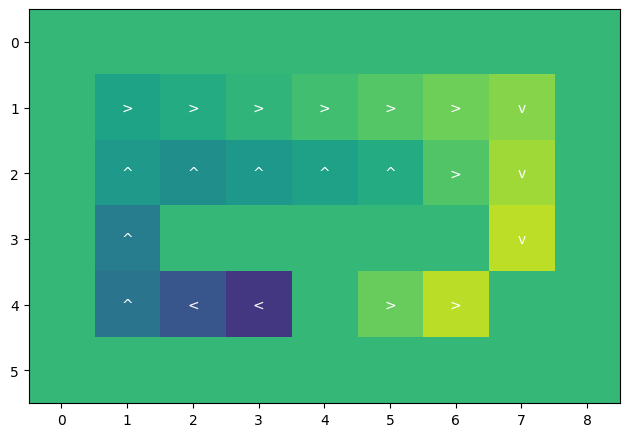

In [11]:
pi = get_policy(lake, v, GAMMA)
plot_v(v, labels=pi)

**Question:** Is there an alternative way that would allow us just to look at a maximum of a function to immediately tell which action to perform? (without computing the expected values)



## VI robustness

First of all, let's notice that we don't have to update all values first and then use the results. We can actually update them asynchronously in-place. Let's try that:

Step 1, MaxDelta: 0.6672423481941223


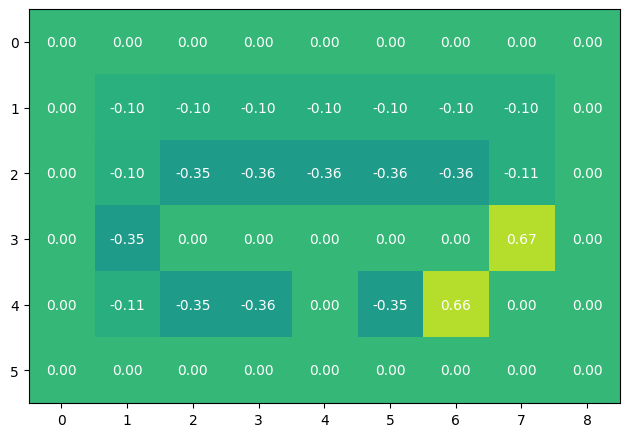

Step 2, MaxDelta: 0.6030316948890686


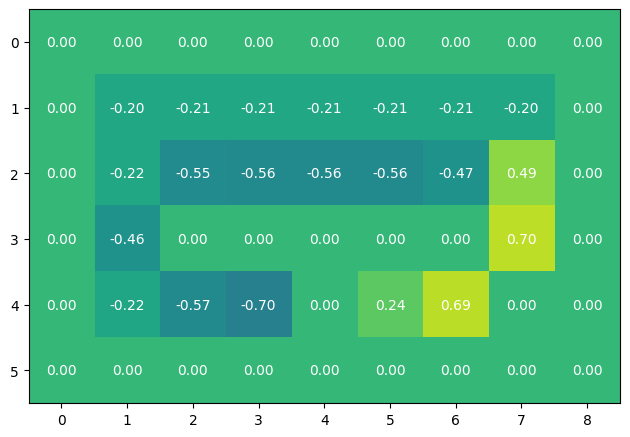

Step 3, MaxDelta: 0.5471059679985046


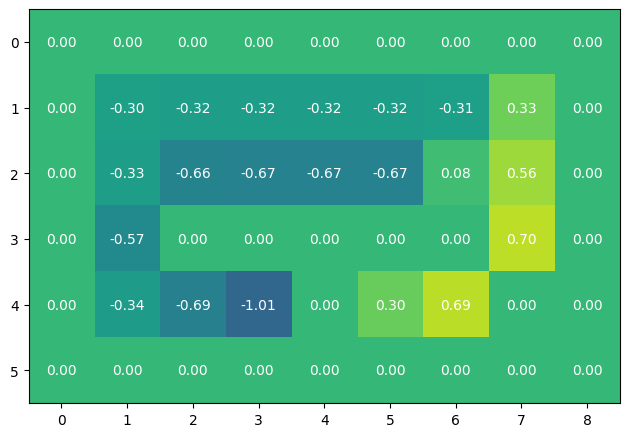

Step 4, MaxDelta: 0.5000737905502319


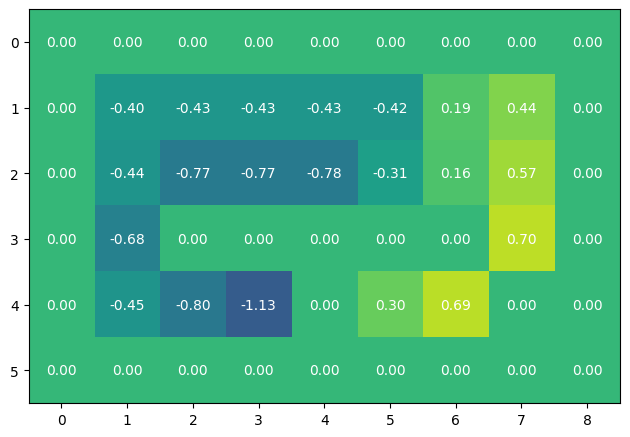

Step 5, MaxDelta: 0.46195852756500244


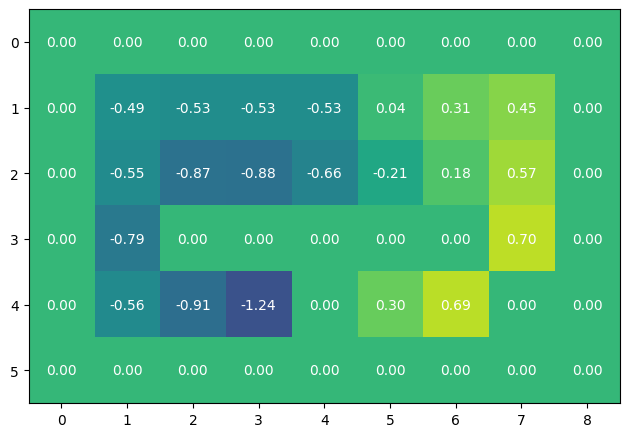

Step 6, MaxDelta: 0.42089545726776123


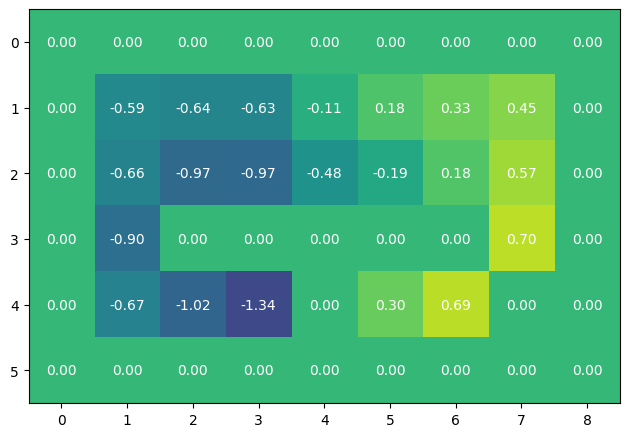

Step 7, MaxDelta: 0.37820523977279663


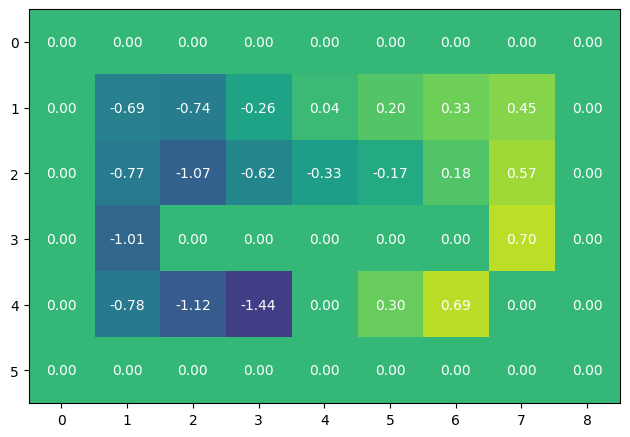

Step 8, MaxDelta: 0.3390238285064697


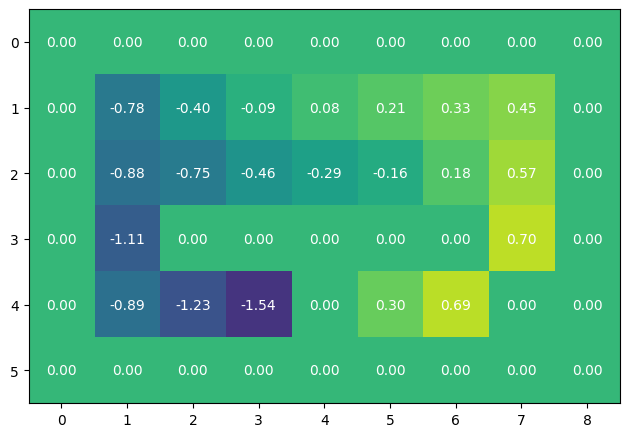

Step 9, MaxDelta: 0.25918322801589966


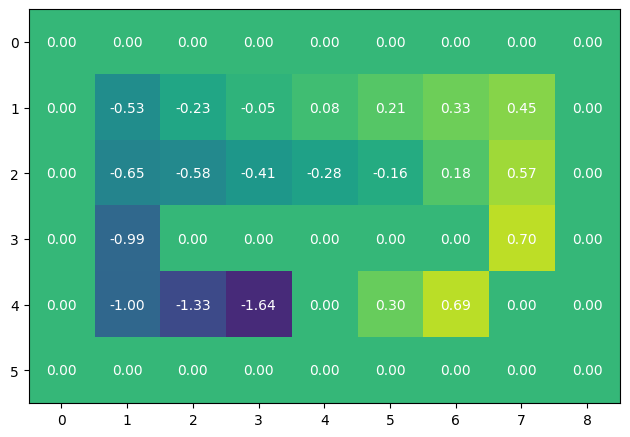

Step 10, MaxDelta: 0.1747857630252838


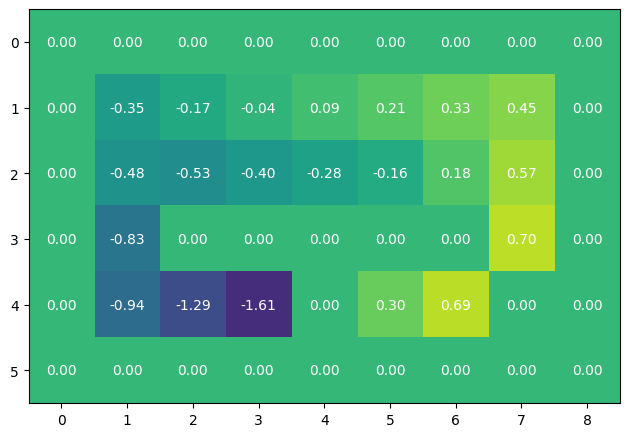

Step 11, MaxDelta: 0.0667242705821991


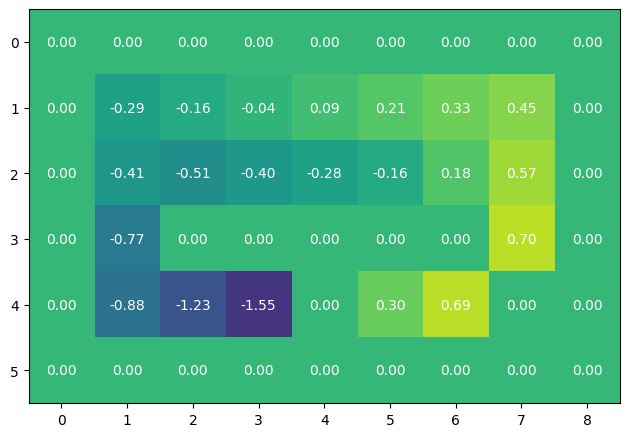

Step 12, MaxDelta: 0.025891542434692383


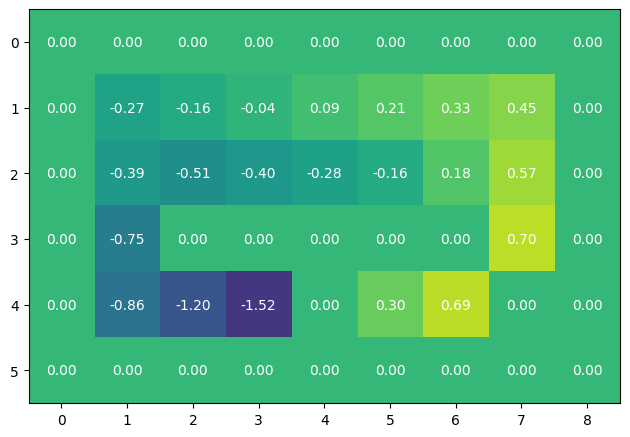

Step 13, MaxDelta: 0.008464694023132324


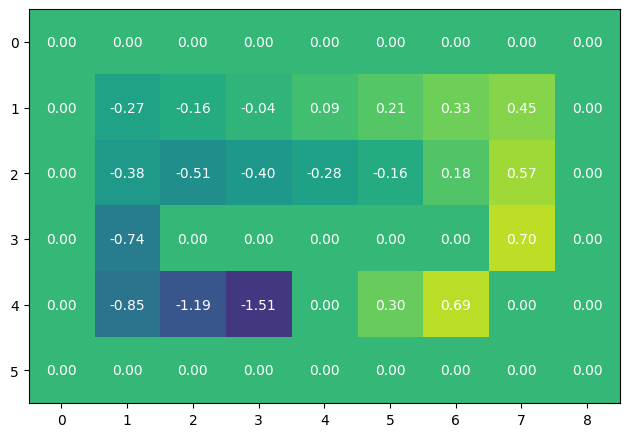

In [12]:
def value_iteration_async(problem: FrozenLake, gamma: float, threshold: float = 0.01):
  v: np.array = np.zeros_like(problem.map, dtype=np.float32)
  max_delta = np.inf
  step = 0
  while max_delta > threshold:
      max_delta = 0.
      step += 1
      for s in problem.get_non_terminal_states():
          q = []
          for a in problem.actions():
              q.append(get_expected_value(problem.get_transitions(s, a), v, gamma))
          v_single_val = max(q)
          max_delta = max(max_delta, np.abs(v_single_val - v[s]))
          v[s] = v_single_val

      print(f"Step {step}, MaxDelta: {max_delta}")
      plot_v(v)
  # Task 
  # - copy the previous function
  # - make the updates asynchronous - don't make a copy of v

  return v

v = value_iteration_async(lake,  GAMMA)

Our new version converged a bit faster, cool!

Another observation is that the order of updates does not matter, as long as we update all states in the end. Maybe there is some optimal order, but for now, let's just look how it goes with a random order:

Step 1, MaxDelta: 0.6700000166893005


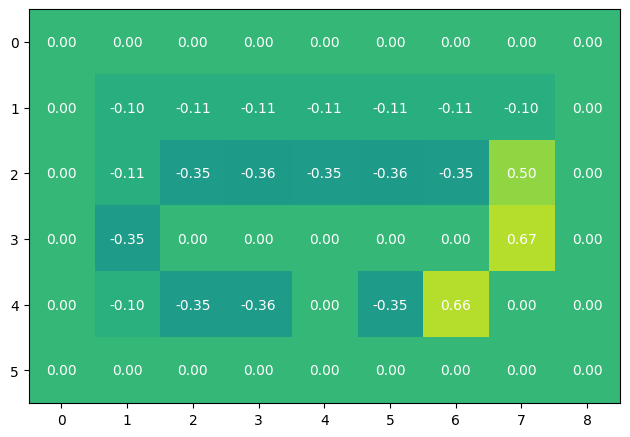

Step 2, MaxDelta: 0.588475227355957


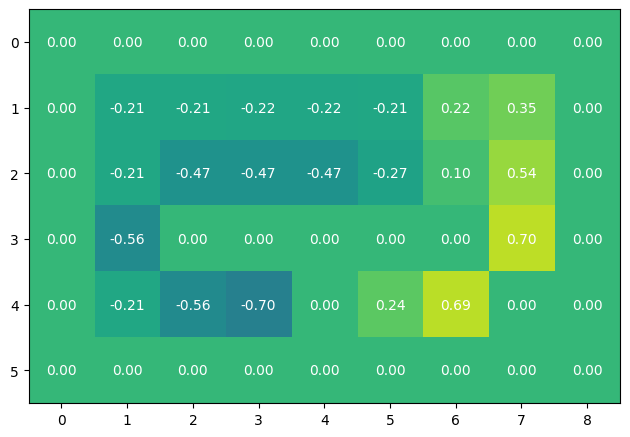

Step 3, MaxDelta: 0.3758976459503174


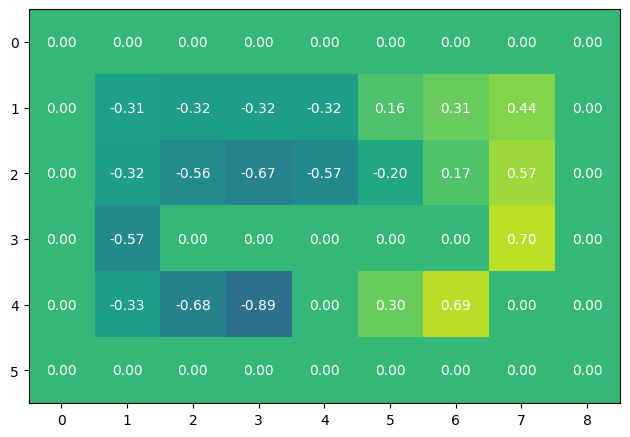

Step 4, MaxDelta: 0.3498290479183197


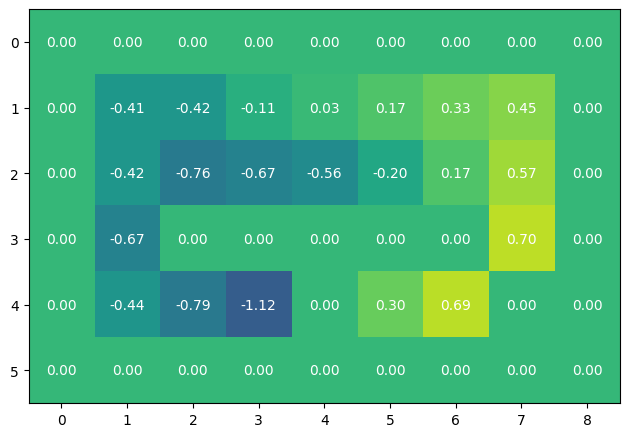

Step 5, MaxDelta: 0.232380211353302


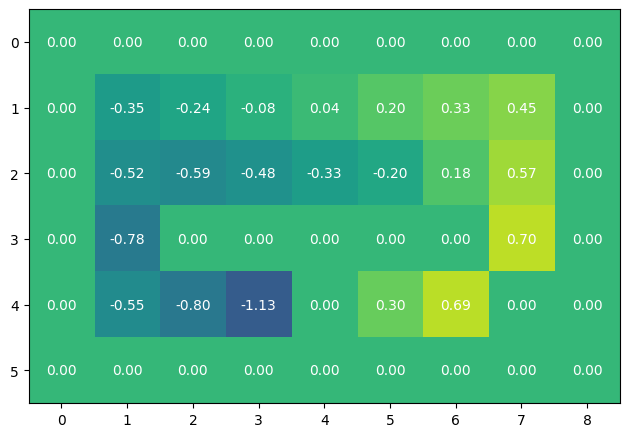

Step 6, MaxDelta: 0.1106405258178711


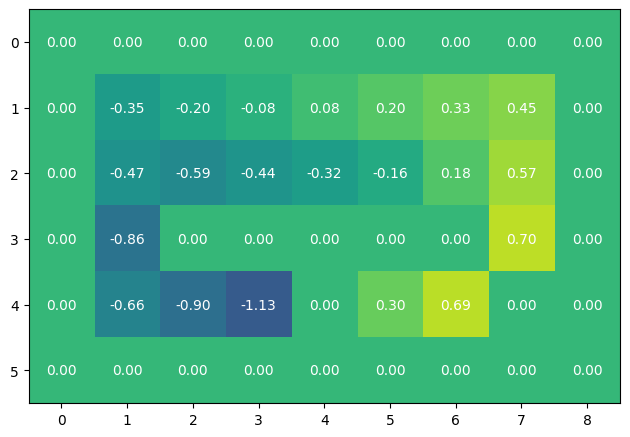

Step 7, MaxDelta: 0.20153987407684326


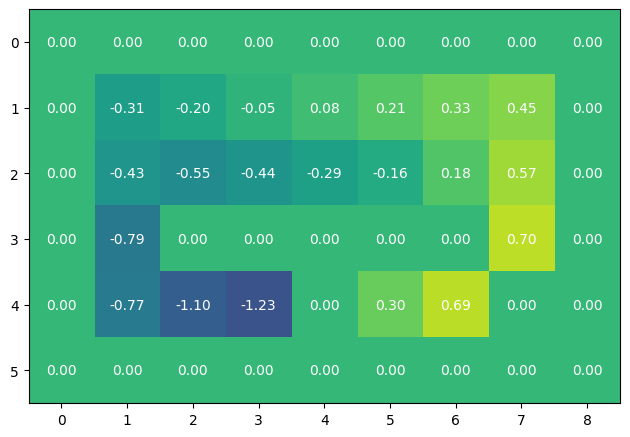

Step 8, MaxDelta: 0.1892843246459961


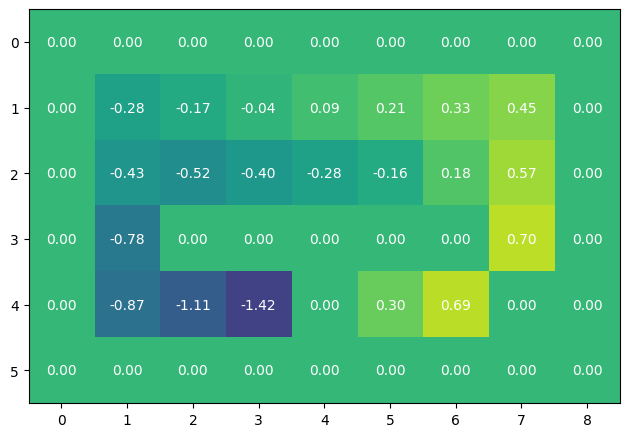

Step 9, MaxDelta: 0.11078131198883057


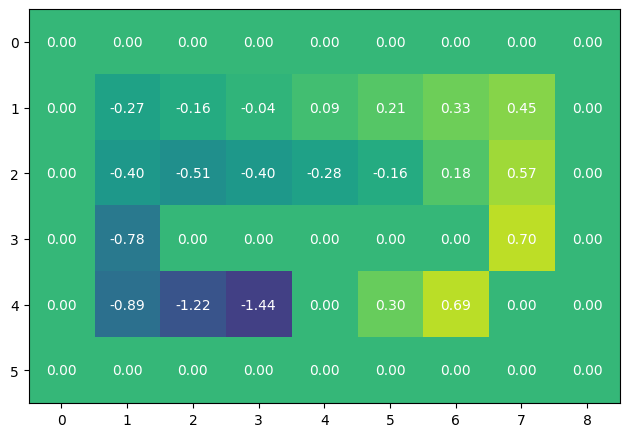

Step 10, MaxDelta: 0.10235011577606201


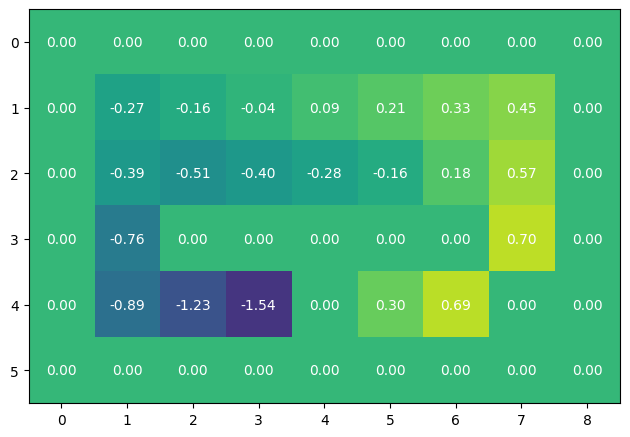

Step 11, MaxDelta: 0.025552809238433838


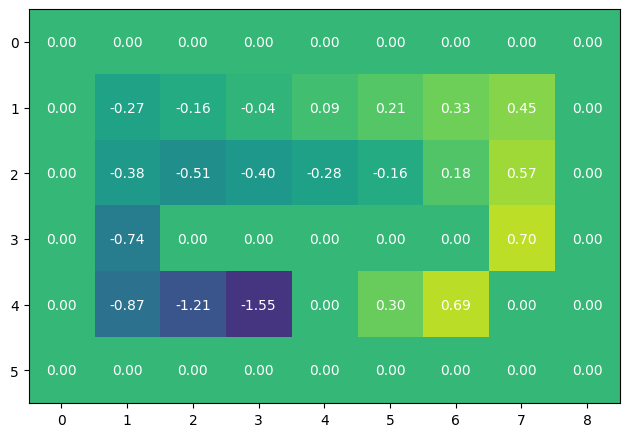

Step 12, MaxDelta: 0.020814061164855957


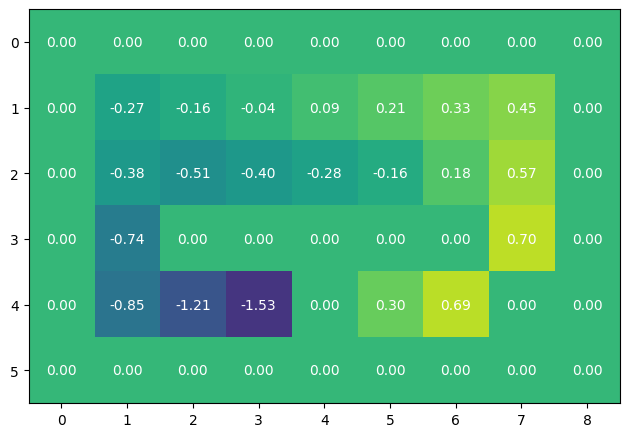

Step 13, MaxDelta: 0.015614032745361328


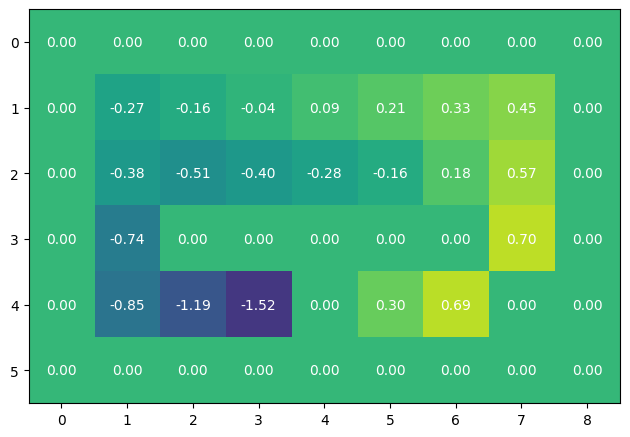

Step 14, MaxDelta: 0.0032088756561279297


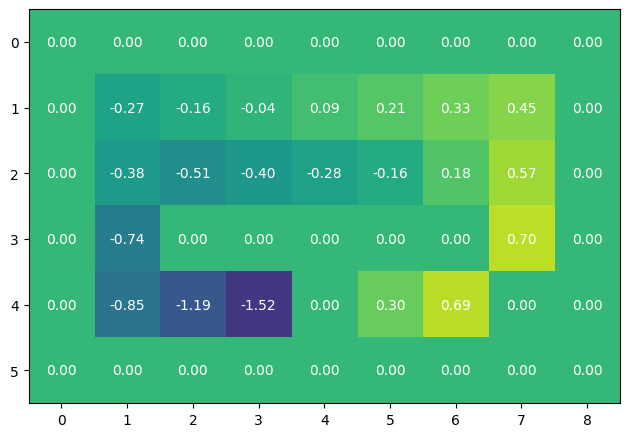

In [17]:
def value_iteration_async_random(problem: FrozenLake, gamma: float, threshold: float = 0.01):
  v: np.array = np.zeros_like(problem.map, dtype=np.float32)
  max_delta = np.inf

  step = 0
  while max_delta > threshold:
      max_delta = 0.
      step += 1
      states = problem.get_non_terminal_states()
      random.shuffle(states)
      for s in states:
          q = []
          for a in problem.actions():
              q.append(get_expected_value(problem.get_transitions(s, a), v, gamma))
          v_single_val = max(q)
          max_delta = max(max_delta, np.abs(v_single_val - v[s]))
          v[s] = v_single_val

      print(f"Step {step}, MaxDelta: {max_delta}")
      plot_v(v)
  # Task 
  # - copy the previous function
  # - update it so it takes random order of updates
  # - you can use `random.sample()` with a complete population size to get a list permutation


  return v

v = value_iteration_async_random(lake,  GAMMA)

Cool, still works. It can converge faster or slower, it's random afterall. 

VI works even for arbitrary initial values, let's try.

Step 1, MaxDelta: 1.1344395875930786


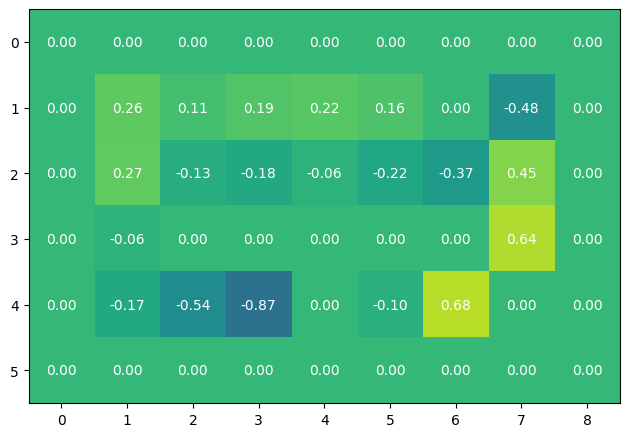

Step 2, MaxDelta: 0.7698489427566528


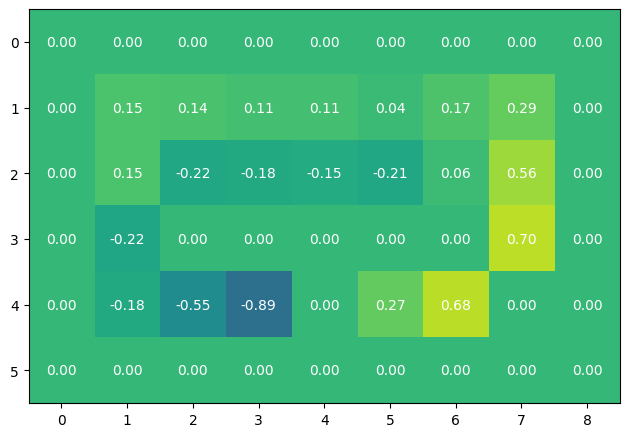

Step 3, MaxDelta: 0.20999865233898163


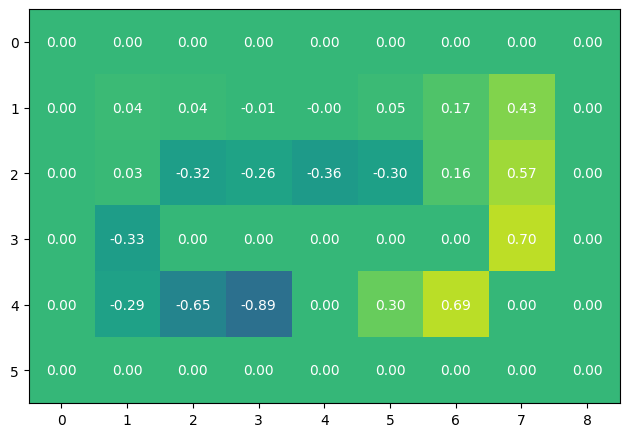

Step 4, MaxDelta: 0.1760922074317932


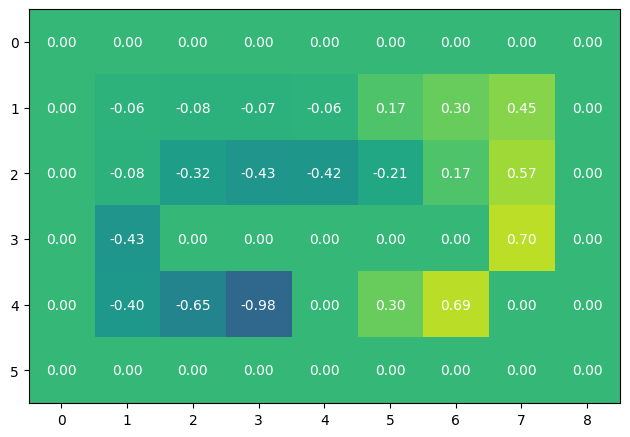

Step 5, MaxDelta: 0.19540178775787354


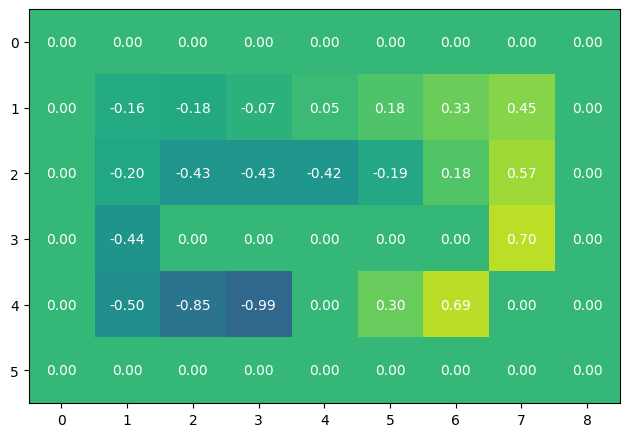

Step 6, MaxDelta: 0.183807373046875


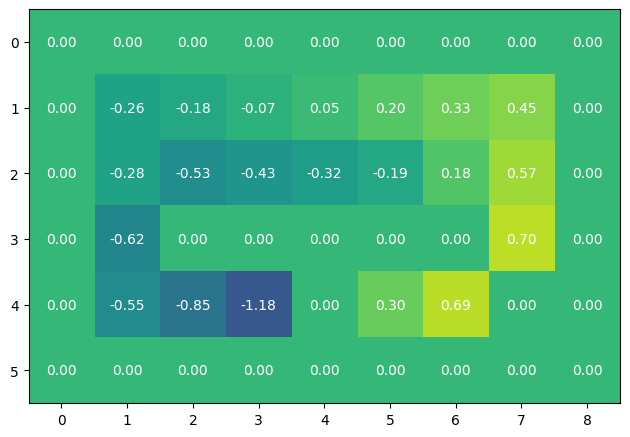

Step 7, MaxDelta: 0.14589476585388184


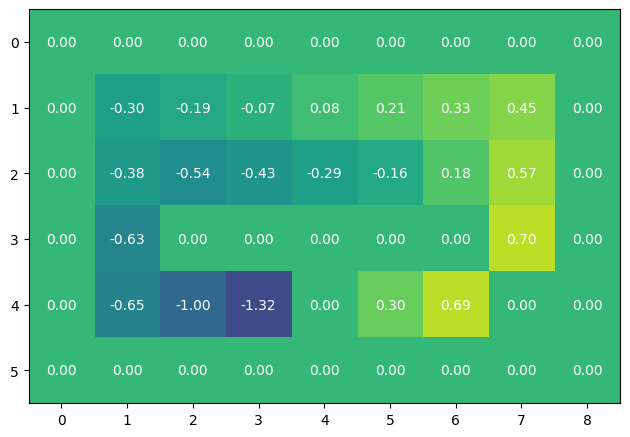

Step 8, MaxDelta: 0.10369247198104858


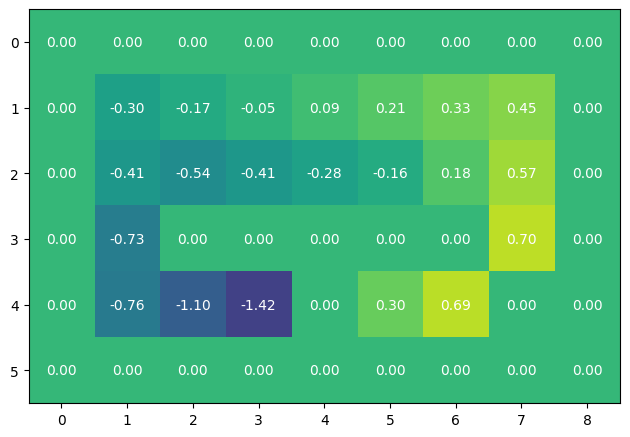

Step 9, MaxDelta: 0.10100424289703369


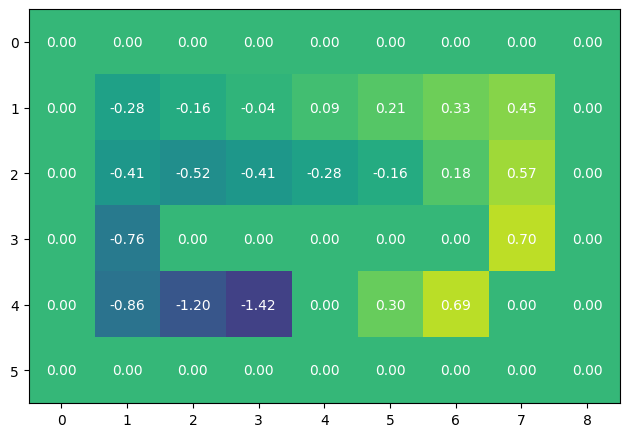

Step 10, MaxDelta: 0.08965456485748291


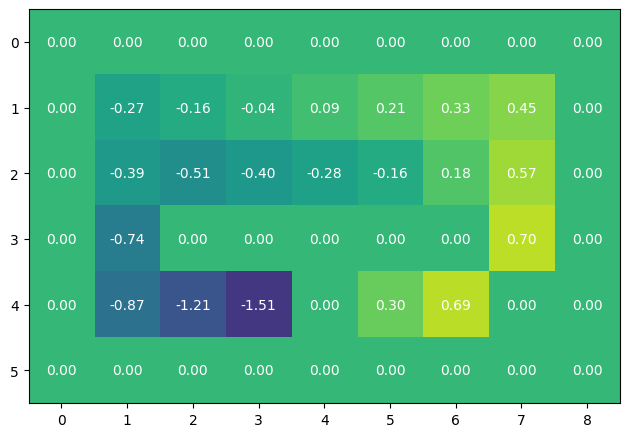

Step 11, MaxDelta: 0.019299626350402832


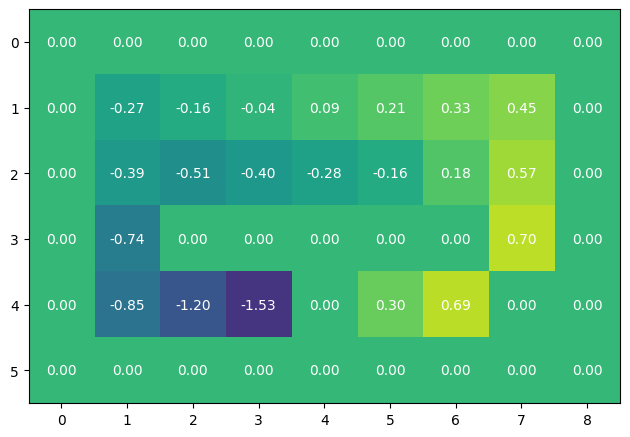

Step 12, MaxDelta: 0.015134692192077637


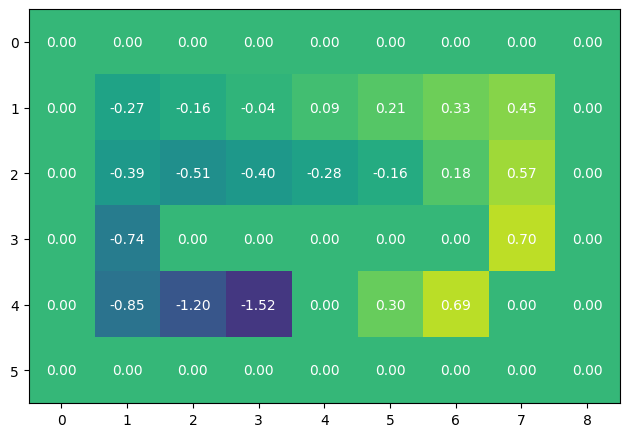

Step 13, MaxDelta: 0.00251615047454834


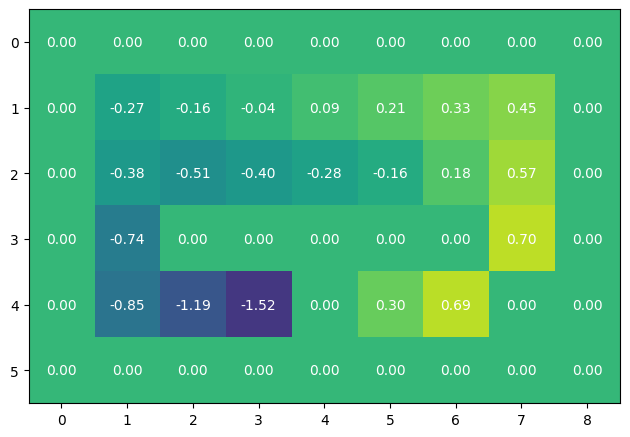

In [20]:
def value_iteration_async_random_randinit(problem: FrozenLake, gamma: float, threshold: float = 0.01):
  v: np.array = np.zeros_like(problem.map, dtype=np.float32)

  for s in problem.get_non_terminal_states():
      v[s] = 2. * (np.random.rand() - 0.5)
  max_delta = np.inf
  step = 0
  while max_delta > threshold:
      max_delta = 0.
      step += 1
      states = problem.get_non_terminal_states()
      random.shuffle(states)
      for s in states:
          q = []
          for a in problem.actions():
              q.append(get_expected_value(problem.get_transitions(s, a), v, gamma))
          v_single_val = max(q)
          max_delta = max(max_delta, np.abs(v_single_val - v[s]))
          v[s] = v_single_val

      print(f"Step {step}, MaxDelta: {max_delta}")
      plot_v(v)
  # Task 
  # - copy the previous function
  # - randomly initialize the value function uniformly in range [-1, 1]
  

  return v

v = value_iteration_async_random_randinit(lake,  GAMMA)

Nice! It still converges.

## Contraction of the Bellman operator

**A bonus task - if there's time.**

Let's prove that the Bellman operator is a contraction!

We need to define some things first. Let's have an MDP with:
- states $\mathcal S = \{s_1, s_2, ..., s_n\}$
- actions $\mathcal A = \{a_1, a_2, ..., a_m\}$
- expected reward $\mathcal R^a_s$ in state $s$ when taking action $a$
- probability $\mathcal P^a_{s,s'}$ of transition $s \xrightarrow{a} s'$
- a discount factor $\gamma \in [0, 1)$

Let $\pi(a|s)$ denote the probability of taking action $a$ in state $s$ under policy $\pi$.

Let's define some more useful quantities. An expected reward under policy $\pi$ is:
$$ \mathbf{R}_\pi(s) = \sum_{a \in \mathcal A} \pi(a|s) \mathcal R^a_s $$

And the probability of transition under policy $\pi$ is:
$$ \mathbf{P}_\pi(s, s') = \sum_{a \in \mathcal A} \pi(a|s) \mathcal P^a_{s, s'} $$

A value function is $v: \mathcal S \rightarrow \mathbb R$. 

For the ease of notation, let's view $v$ as a vector of values $[v(s_1), v(s_2), ..., v(s_n)]$. Similarly, let's overload $\mathbf R_\pi = [\mathbf R_\pi(s_1), \mathbf R_\pi(s_2), ..., \mathbf R_\pi(s_n)]$ and $\mathbf P_\pi$ as a matrix $\mathbf P_\pi = [\mathbf P_\pi(s_i, s_j)]; i,j \in \{1..n\}$.

A value function for a policy $\pi$ satisfies $v_\pi = \mathbf R_\pi +  \gamma \mathbf P_\pi v_\pi$. 

<!-- An optimal value function $v_*(s) = \max_{\pi} v_\pi(s), \forall s$ satisfies $v_*(s) = \mathbf R_\pi(s) + \gamma \max_a v_*(s')$ -->

Let $\mathbf B_\pi$ be a *Bellman policy operator*: $\mathbf B_\pi v = \mathbf R_\pi + \gamma \mathbf P_\pi v$.

Let $||\mathbf x||_\infty = \max(x_1, x_2, ...)$ be a *max* norm.


**Task:** Prove that $\mathbf B_\pi$ is a contraction under *max* norm, i.e. $|| \mathbf B_\pi v_1 - \mathbf B_\pi v_2||_\infty \leq \gamma || v_1 - v_2 ||_\infty$ for any $v_1, v_2$.



---



Since $\mathbf B_\pi$ is a contraction, then we can apply the Contraction Mapping Theorem (see https://en.wikipedia.org/wiki/Banach_fixed-point_theorem) to claim it has a unique fixed point, which is $v_\pi$. 

Similarly, the *Bellman Optimality operator* $\mathbf (\mathbf B_* v)(s) = \max_a \left[ \mathcal R_s^a + \gamma \sum_{s' \in \mathcal S} \mathcal P^a_{s,s'} v(s') \right]$ converges to $v_*$. (proof as a homework ;-)).